In [1]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [2]:
!kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 86% 299M/346M [00:00<00:00, 830MB/s] 
100% 346M/346M [00:02<00:00, 144MB/s]


In [3]:
!unzip intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [4]:
train_path = '/content/seg_train/seg_train'
test_path = '/content/seg_pred/seg_pred'
val_path = '/content/seg_test/seg_test'

In [5]:
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32

In [21]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

train_ds = image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = image_dataset_from_directory(
    val_path,
    labels='inferred',
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_ds = image_dataset_from_directory(
    test_path,
    labels=None,
    image_size=IMAGE_SIZE,
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
print("\nClass names: ", class_names, "\nNumber of Classes: ", len(class_names))

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.
Found 7301 files.

Class names:  ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street'] 
Number of Classes:  6


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

data_augmentation = tf.keras.Sequential([
    RandomFlip('horizontal_and_vertical'),
    RandomRotation(0.2),
    RandomZoom(0.2)
])

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

INPUT_SHAPE = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
NUM_CLASSES = len(class_names)

model_test = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(NUM_CLASSES, activation='softmax')
])

model_test.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     9,470,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,564,998 (36.49 MB)

 Trainable params: 9,564,998 (36.49 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model_test.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
history = model_test.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 81s 171ms/step - accuracy: 0.2313 - loss: 22.0013 - val_accuracy: 0.1913 - val_loss: 1.7870
Epoch 2/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - accuracy: 0.2071 - loss: 1.7823 - val_accuracy: 0.2017 - val_loss: 1.7745
Epoch 3/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.2151 - loss: 1.7666 - val_accuracy: 0.2153 - val_loss: 1.7900
Epoch 4/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.2309 - loss: 1.7479 - val_accuracy: 0.2233 - val_loss: 1.8724
Epoch 5/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.2559 - loss: 1.6980 - val_accuracy: 0.2407 - val_loss: 1.9183
Epoch 6/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.3067 - loss: 1.6548 - val_accuracy: 0.2437 - val_loss: 2.3963
Epoch 7/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.4172 - loss: 1.4451 - val_accuracy: 0.3837 - val_loss: 1.8714
Epoch 8/10
439/439 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.4813 - loss: 1.3071 

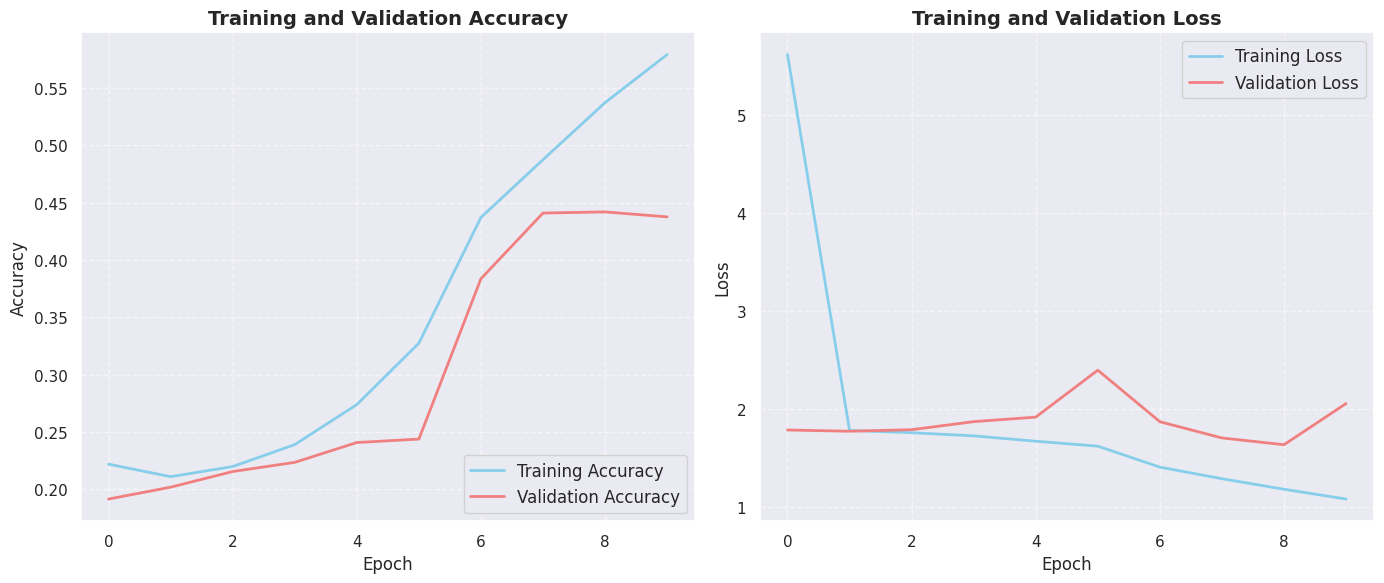

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

# Get the accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 6))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='skyblue', linewidth=2)
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='lightcoral', linewidth=2)
plt.legend(loc='lower right', fontsize=12)
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='skyblue', linewidth=2)
plt.plot(epochs_range, val_loss, label='Validation Loss', color='lightcoral', linewidth=2)
plt.legend(loc='upper right', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


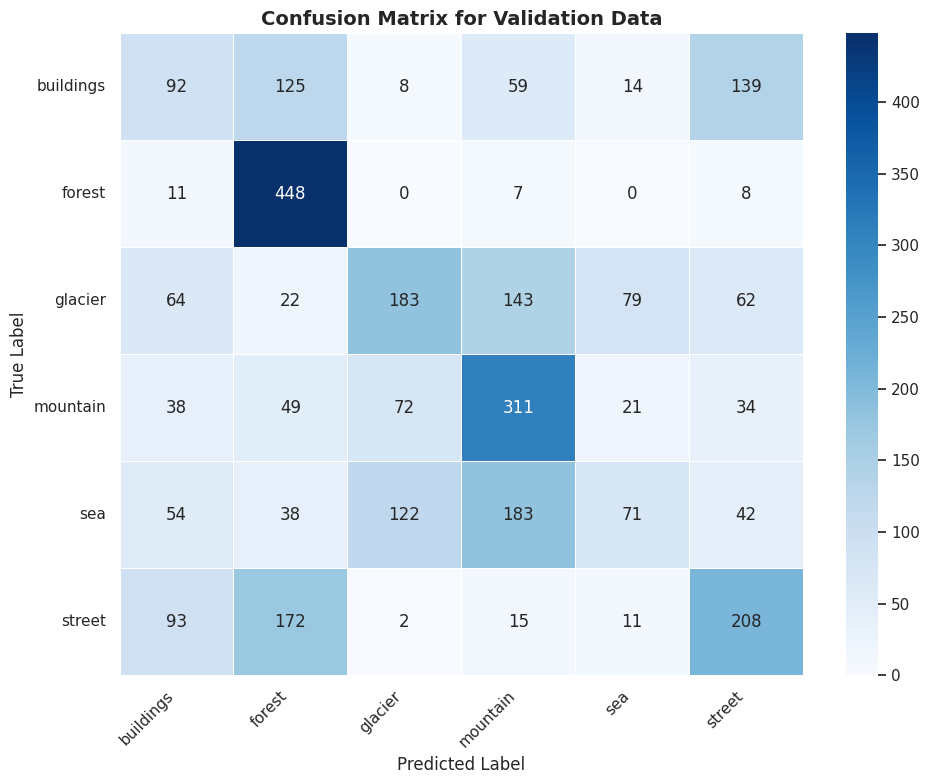

In [12]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="darkgrid")

# 1. Get true labels from the validation dataset
y_true = []
for images, labels in val_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
# Convert to numpy array
y_true = np.array(y_true)

# 2. Get predictions from the model on the validation dataset
y_pred_probs = model_test.predict(val_ds)
# Get the class with the highest probability for each prediction
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 4. Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=.5,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix for Validation Data', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [24]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomBrightness

data_augmentation = tf.keras.Sequential([
    RandomFlip('horizontal_and_vertical'),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(factor=0.2), # Adding RandomContrast
    RandomBrightness(factor=0.2) # Adding RandomBrightness
])

# Reapply data augmentation to the training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("Data augmentation enhanced with RandomContrast and RandomBrightness and reapplied to train_ds.")

Data augmentation enhanced with RandomContrast and RandomBrightness and reapplied to train_ds.


In [25]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers

custom_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE, kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(NUM_CLASSES, activation='softmax')
])

custom_model.summary()
print("Custom model redefined with L2 regularization.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,949,318 (26.51 MB)

 Trainable params: 6,946,822 (26.50 MB)

 Non-trainable params: 2,496 (9.75 KB)

Custom model redefined with L2 regularization.


In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,  # Adjusted factor
    patience=3,  # Adjusted patience
    min_lr=0.000001,
    verbose=1
)

print("EarlyStopping and ReduceLROnPlateau callbacks defined with adjusted parameters.")

EarlyStopping and ReduceLROnPlateau callbacks defined with adjusted parameters.


In [27]:
from tensorflow.keras.optimizers import Adam

custom_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

custom_model.summary()
print("Custom model recompiled with Adam optimizer.")

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,949,318 (26.51 MB)

 Trainable params: 6,946,822 (26.50 MB)

 Non-trainable params: 2,496 (9.75 KB)

Custom model recompiled with Adam optimizer.


In [28]:
# Train the custom model with the defined callbacks
history_custom_model = custom_model.fit(
    train_ds,
    epochs=100, # Start with a reasonable number of epochs; EarlyStopping will manage when to stop
    validation_data=val_ds,
    callbacks=[early_stopping, reduce_lr] # Pass the list of callbacks here
)

Epoch 1/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 94s 192ms/step - accuracy: 0.4259 - loss: 1.9329 - val_accuracy: 0.5610 - val_loss: 1.4049 - learning_rate: 0.0010
Epoch 2/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.5578 - loss: 1.4065 - val_accuracy: 0.5147 - val_loss: 1.4165 - learning_rate: 0.0010
Epoch 3/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.6086 - loss: 1.2208 - val_accuracy: 0.5417 - val_loss: 1.4174 - learning_rate: 0.0010
Epoch 4/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.6424 - loss: 1.1020 - val_accuracy: 0.5707 - val_loss: 1.2549 - learning_rate: 0.0010
Epoch 5/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.6713 - loss: 1.0209 - val_accuracy: 0.6083 - val_loss: 1.1699 - learning_rate: 0.0010
Epoch 6/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 36ms/step - accuracy: 0.6936 - loss: 0.9856 - val_accuracy: 0.5447 - val_loss: 1.5161 - learning_rate: 0.0010
Epoch 7/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.

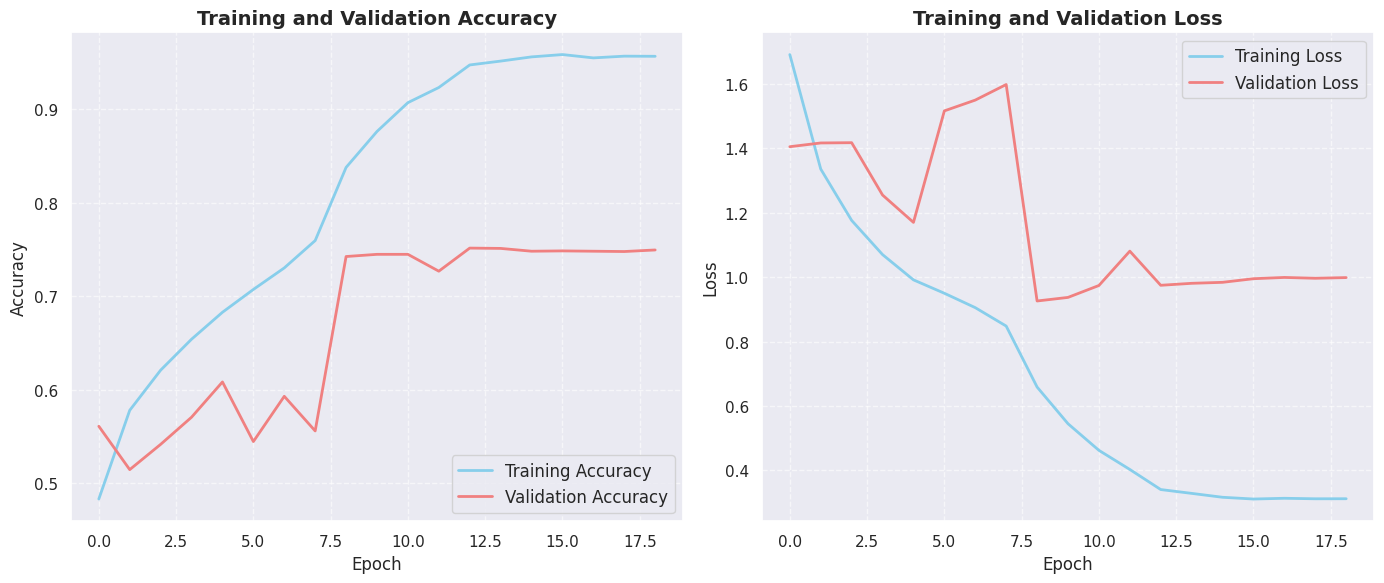

In [29]:
sns.set_theme(style="darkgrid")

# Get the accuracy and loss values from the history object
acc = history_custom_model.history['accuracy']
val_acc = history_custom_model.history['val_accuracy']
loss = history_custom_model.history['loss']
val_loss = history_custom_model.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 6))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='skyblue', linewidth=2)
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='lightcoral', linewidth=2)
plt.legend(loc='lower right', fontsize=12)
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='skyblue', linewidth=2)
plt.plot(epochs_range, val_loss, label='Validation Loss', color='lightcoral', linewidth=2)
plt.legend(loc='upper right', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step


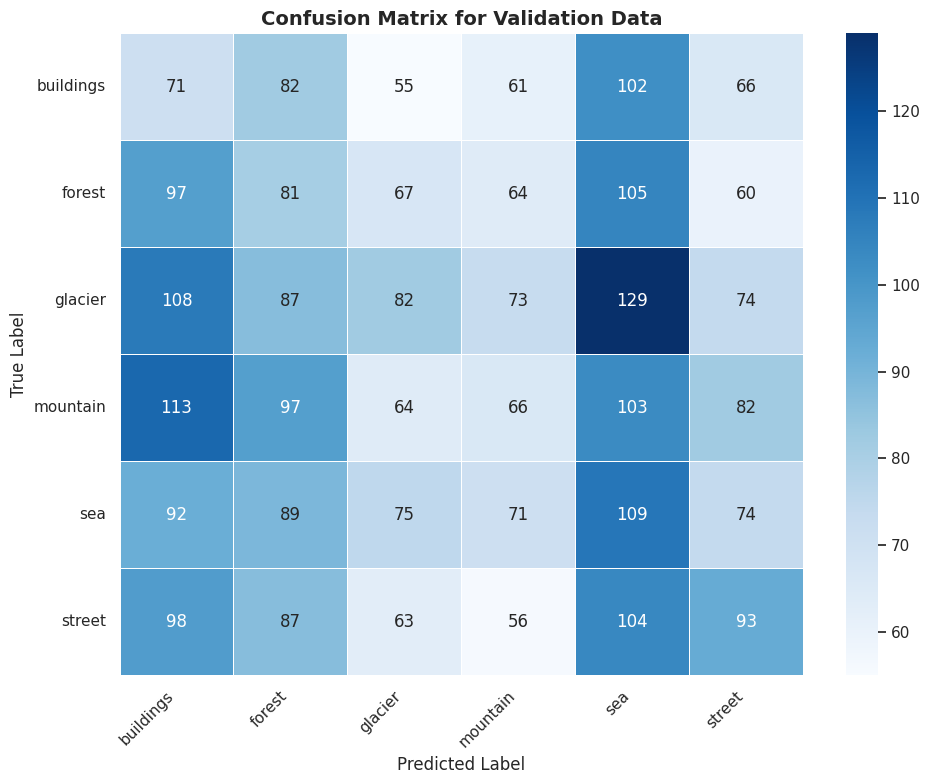

In [30]:
sns.set_theme(style="darkgrid")

# 1. Get true labels from the validation dataset
y_true = []
for images, labels in val_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
# Convert to numpy array
y_true = np.array(y_true)

# 2. Get predictions from the model on the validation dataset
y_pred_probs = custom_model.predict(val_ds)
# Get the class with the highest probability for each prediction
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 4. Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=.5,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix for Validation Data', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [31]:
loss, accuracy = custom_model.evaluate(val_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.7392 - loss: 0.9415
Test Loss: 0.9259
Test Accuracy: 0.7423


In [41]:
from tensorflow.keras.applications import ResNet50

# 1. Load a pre-trained convolutional base (ResNet50) without the top classification layer
conv_base = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE
)

# 2. Set the trainable attribute of all layers in the loaded pre-trained model to False
for layer in conv_base.layers:
    layer.trainable = False

# Print the summary of the base model to verify its architecture and that the layers are frozen
print("Pre-trained ResNet50 convolutional base loaded and layers frozen.")

Pre-trained ResNet50 convolutional base loaded and layers frozen.


In [33]:
from tensorflow.keras import layers, models

# Create a new model on top of the pre-trained convolutional base
model = models.Sequential([
    conv_base,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Display the model summary to confirm the architecture
model.summary()
print("New model created with ResNet50 convolutional base and custom classification head.")

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 5, 5, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │    13,107,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,696,710 (139.99 MB)

 Trainable params: 13,108,998 (50.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

New model created with ResNet50 convolutional base and custom classification head.


In [42]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("New model compiled and ready for training.")

New model compiled and ready for training.


In [35]:
history_transfer_learning_model = model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    callbacks=[early_stopping, reduce_lr]
)
print("Transfer learning model training initiated.")

Epoch 1/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 49s 85ms/step - accuracy: 0.6273 - loss: 2.8395 - val_accuracy: 0.8370 - val_loss: 0.5767 - learning_rate: 0.0010
Epoch 2/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 63s 56ms/step - accuracy: 0.7554 - loss: 0.6963 - val_accuracy: 0.8523 - val_loss: 0.4775 - learning_rate: 0.0010
Epoch 3/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 58ms/step - accuracy: 0.7933 - loss: 0.5905 - val_accuracy: 0.8560 - val_loss: 0.4531 - learning_rate: 0.0010
Epoch 4/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 26s 58ms/step - accuracy: 0.8263 - loss: 0.5050 - val_accuracy: 0.8487 - val_loss: 0.4558 - learning_rate: 0.0010
Epoch 5/100
439/439 ━━━━━━━━━━━━━━━━━━━━ 26s 60ms/step - accuracy: 0.8346 - loss: 0.4708 - val_accuracy: 0.8553 - val_loss: 0.4929 - learning_rate: 0.0010
Epoch 6/100
438/439 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8454 - loss: 0.4351
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
439/439 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - accuracy: 0.845

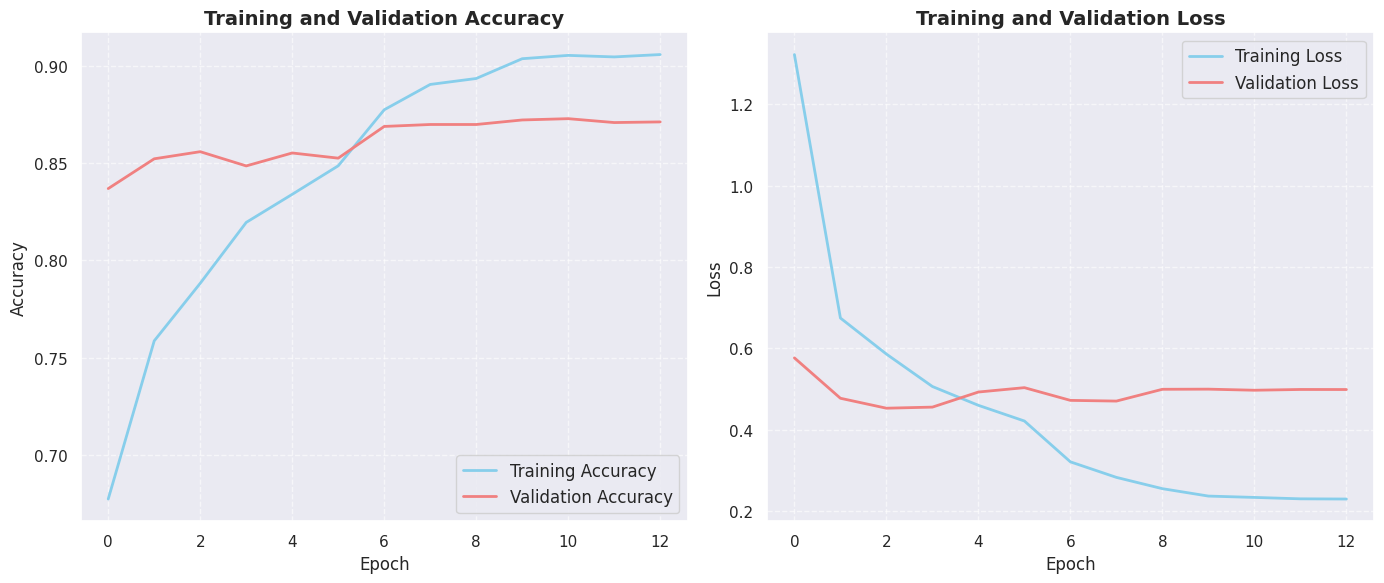

In [36]:
sns.set_theme(style="darkgrid")

# Get the accuracy and loss values from the history object
acc = history_transfer_learning_model.history['accuracy']
val_acc = history_transfer_learning_model.history['val_accuracy']
loss = history_transfer_learning_model.history['loss']
val_loss = history_transfer_learning_model.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 6))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', color='skyblue', linewidth=2)
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='lightcoral', linewidth=2)
plt.legend(loc='lower right', fontsize=12)
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', color='skyblue', linewidth=2)
plt.plot(epochs_range, val_loss, label='Validation Loss', color='lightcoral', linewidth=2)
plt.legend(loc='upper right', fontsize=12)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

94/94 ━━━━━━━━━━━━━━━━━━━━ 13s 95ms/step


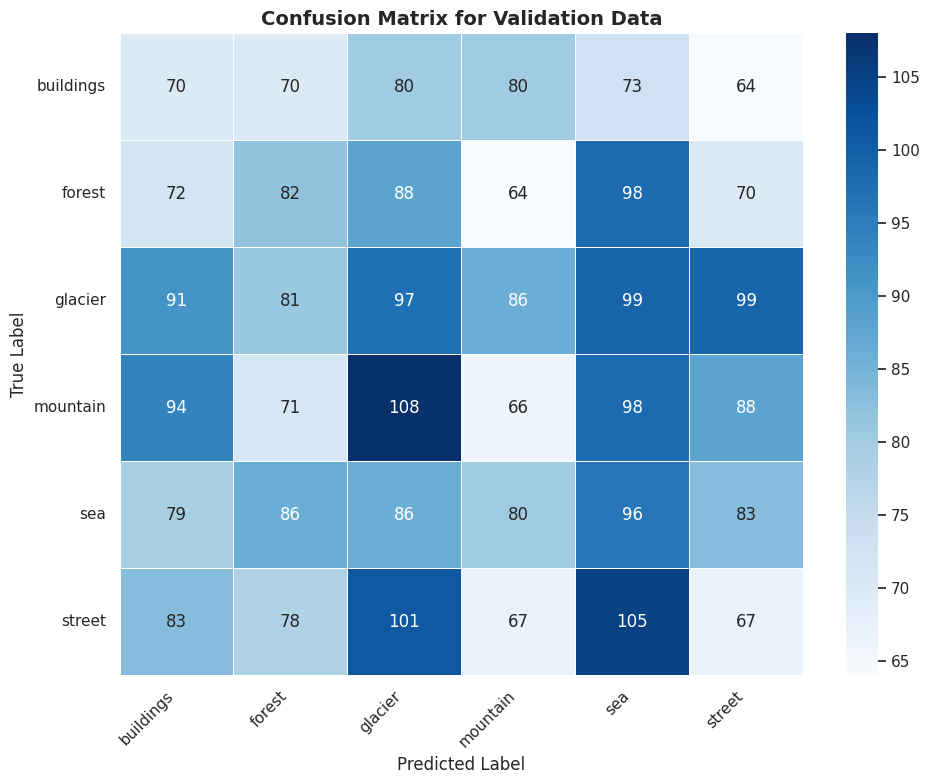

In [38]:
sns.set_theme(style="darkgrid")

# 1. Get true labels from the validation dataset
y_true = []
for images, labels in val_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
# Convert to numpy array
y_true = np.array(y_true)

# 2. Get predictions from the model on the validation dataset
y_pred_probs = model.predict(val_ds)
# Get the class with the highest probability for each prediction
y_pred = np.argmax(y_pred_probs, axis=1)

# 3. Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 4. Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=.5,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix for Validation Data', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [40]:
loss, accuracy = model.evaluate(val_ds)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.8558 - loss: 0.4650
Test Loss: 0.4531
Test Accuracy: 0.8560
